In [5]:
%cd ~/bench

/home/soda/rcappuzz/work/benchmark-join-suggestions


In [119]:
%load_ext autoreload
%autoreload 2
import polars as pl
import seaborn as sns
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import matplotlib.colors as mcolors
import src.utils.plotting as plotting
from src.utils.logging import read_logs
from matplotlib.gridspec import GridSpec

import tarfile
import json
import pandas as pd 
cfg = pl.Config()
cfg.set_fmt_str_lengths(150)

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


polars.config.Config

# Combine all results 

In [405]:
root_path = Path("results/big_batch")
df_list = []
for rpath in root_path.iterdir():
    df_raw = read_logs(exp_name=None, exp_path=rpath)
    df_list.append(df_raw)

df_results = pl.concat(df_list)

# BIG BATCH

In [406]:
df_ = df_results.select(
    pl.col(
        [
            "scenario_id",
            "target_dl",
            "jd_method",
            "base_table",
            "estimator",
            "chosen_model",
            "aggregation",
            "r2score",
            "time_fit",
            "time_predict",
            "time_run",
            "epsilon",
        ]
    )
).filter(
    (~pl.col("base_table").str.contains("open_data"))
    & (pl.col("target_dl") != "wordnet_big")
)

In [407]:
df_ = df_.with_columns(
    (pl.col("jd_method") + " | " + pl.col("target_dl")).alias("case")
)

In [415]:
joined = (
    df_.join(
        df_.filter(pl.col("estimator") == "nojoin"),
        on=["target_dl", "jd_method", "base_table", "chosen_model"],
        how="left",
    )
    .group_by(["target_dl", "jd_method", "base_table", "chosen_model", "estimator"])
    .agg(
        pl.mean("r2score").alias("avg_r2"),
        pl.mean("r2score_right").alias("avg_r2_nojoin"),
    )
    .with_columns((pl.col("avg_r2") - pl.col("avg_r2_nojoin")).alias("difference"))
)

In [504]:
nojoin_avg = (
    df_.filter(pl.col("estimator") == "nojoin")
    .group_by(["target_dl", "jd_method", "base_table", "chosen_model", "estimator"])
    .agg(pl.mean("r2score"))
)

In [505]:
nojoin_avg

target_dl,jd_method,base_table,chosen_model,estimator,r2score
str,str,str,str,str,f64
"""binary_update""","""minhash""","""company-employees-yadl""","""linear""","""nojoin""",0.703571
"""binary_update""","""minhash""","""us-elections-yadl-depleted""","""linear""","""nojoin""",-0.017894
"""binary_update""","""exact_matching""","""movies-yadl""","""linear""","""nojoin""",0.44115
"""binary_update""","""exact_matching""","""movies-yadl-depleted""","""catboost""","""nojoin""",-0.001563
"""wordnet_full_flat""","""exact_matching""","""housing-prices-yadl""","""linear""","""nojoin""",0.688221
"""binary_update""","""exact_matching""","""movies-yadl-depleted""","""linear""","""nojoin""",-0.001416
"""binary_update""","""exact_matching""","""movies-vote-yadl-depleted""","""catboost""","""nojoin""",-0.001642
"""wordnet_full_flat""","""exact_matching""","""housing-prices-yadl-depleted""","""catboost""","""nojoin""",-0.000356
"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""linear""","""nojoin""",-0.001361


In [506]:
# nojoin_avg is the average of nojoins for each group
joined = (
    df_.join(
        nojoin_avg,
        on=["target_dl", "jd_method", "base_table", "chosen_model"],
        how="left",
    )
    .sort(["jd_method", "base_table", "chosen_model"])
    .with_columns((pl.col("r2score") - pl.col("r2score_right")).alias("difference"))
)

In [508]:
col_order = (
    df_.select(pl.col("base_table")).unique().sort("base_table").to_series().to_list()
)

# Early Seaborn plots

KeyboardInterrupt: 

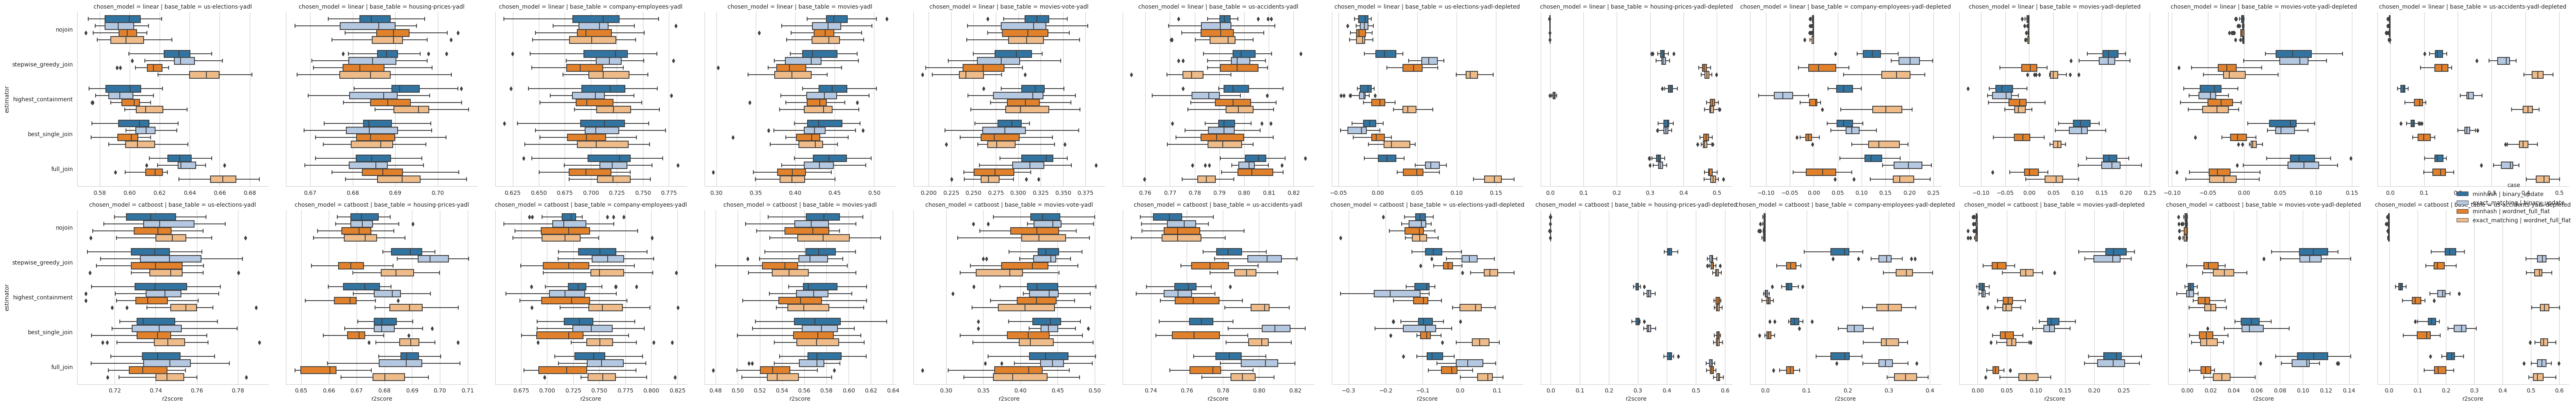

In [509]:
with sns.axes_style("whitegrid"):
    ax = sns.catplot(
        data=df_.filter(~pl.col("base_table").str.contains("open_data")).to_pandas(),
        # data=df_.filter(pl.col("chosen_model") == "catboost").to_pandas(),
        x="r2score",
        y="estimator",
        hue="case",
        kind="box",
        col="base_table",
        row="chosen_model",
        sharex=False,
        # col_wrap=2,
        # col_order=col_order,
        # facet_kws={"xlim": [0,1]}
        palette="tab20",
    )

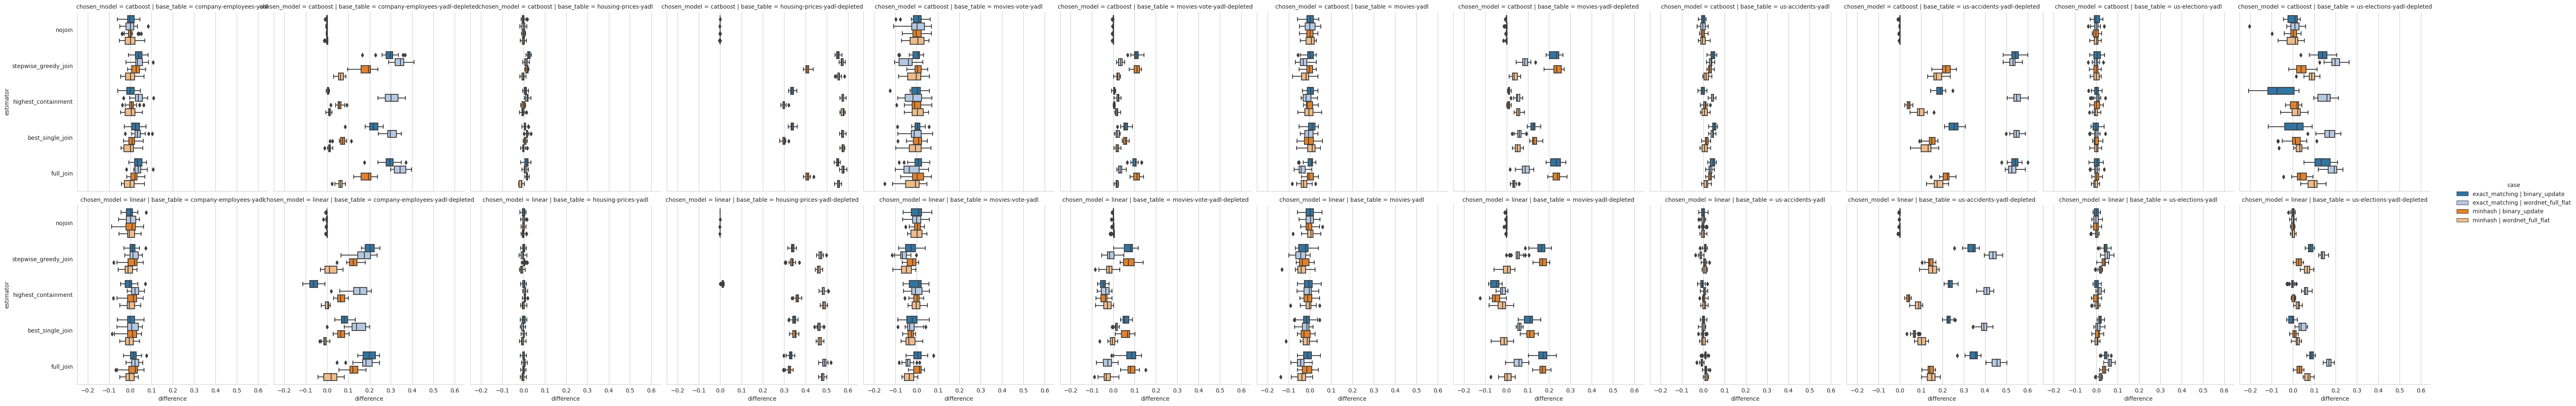

In [ ]:
with sns.axes_style("whitegrid"):
    ax = sns.catplot(
        data=joined.filter(~pl.col("base_table").str.contains("open_data")).to_pandas(),
        # data=df_.filter(pl.col("chosen_model") == "catboost").to_pandas(),
        x="difference",
        y="estimator",
        hue="case",
        kind="box",
        col="base_table",
        row="chosen_model",
        sharex=True,
        # col_wrap=2,
        # col_order=col_order,
        # facet_kws={"xlim": [0,1]}
        palette="tab20",
    )

In [ ]:
for table in df_["base_table"].unique().sort():
    ax = sns.catplot(
        data=df_.filter(pl.col("base_table") == table).to_pandas(),
        y="r2score",
        x="estimator",
        hue="case",
        kind="box",
        # col="base_table",
        col="chosen_model",
        # sharex=True,
        # col_wrap=2,
        # col_order=col_order,
        # facet_kws={"xlim": [0,1]}
        palette="tab20",
    )
    ax.set_xticklabels(rotation=30)
    ax.fig.subplots_adjust(top=0.9)

    ax.fig.suptitle(table)

In [ ]:
for table in joined["base_table"].unique().sort():
    ax = sns.catplot(
        data=joined.filter(pl.col("base_table") == table).to_pandas(),
        y="difference",
        x="estimator",
        hue="case",
        kind="box",
        # col="base_table",
        col="chosen_model",
        # sharex=True,
        # col_wrap=2,
        # col_order=col_order,
        # facet_kws={"xlim": [0,1]}
        palette="tab20",
    )
    ax.set_xticklabels(rotation=30)
    ax.fig.subplots_adjust(top=0.9)

    ax.fig.suptitle(table)

# Post-hoc

In [510]:
joined.head()

scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,case,estimator_right,r2score_right,difference
i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,str,f64,f64
86,"""binary_update""","""exact_matching""","""company-employees-yadl""","""nojoin""","""catboost""","""first""",0.708131,1.122778,0.008693,1.132397,null,"""exact_matching | binary_update""","""nojoin""",0.718649,-0.010518
86,"""binary_update""","""exact_matching""","""company-employees-yadl""","""stepwise_greedy_join""","""catboost""","""first""",0.743079,44.548097,0.382367,44.931376,0.0,"""exact_matching | binary_update""","""nojoin""",0.718649,0.02443
86,"""binary_update""","""exact_matching""","""company-employees-yadl""","""highest_containment""","""catboost""","""first""",0.719938,11.330839,0.398565,11.730513,null,"""exact_matching | binary_update""","""nojoin""",0.718649,0.001289
86,"""binary_update""","""exact_matching""","""company-employees-yadl""","""best_single_join""","""catboost""","""first""",0.709677,34.384208,0.083322,34.468704,null,"""exact_matching | binary_update""","""nojoin""",0.718649,-0.008973
86,"""binary_update""","""exact_matching""","""company-employees-yadl""","""full_join""","""catboost""","""first""",0.733777,14.378174,5.433314,19.812275,null,"""exact_matching | binary_update""","""nojoin""",0.718649,0.015127


In [511]:
results_full = joined.filter(~pl.col("base_table").str.contains("depleted"))
results_depleted = joined.filter(pl.col("base_table").str.contains("depleted"))

In [512]:
max_diff_depleted = (
    results_depleted.select(
        pl.col("estimator"), pl.col("chosen_model"), pl.col("difference")
    )
    .group_by("estimator")
    .agg(pl.max("difference"))
)

In [513]:
max_diff_depleted = results_depleted.select(pl.col("difference").abs().max()).item()

In [514]:
results_depleted = results_depleted.with_columns(
    (pl.col("difference") / max_diff_depleted).alias("scaled_diff")
)

In [515]:
results_depleted.head()

scenario_id,target_dl,jd_method,base_table,estimator,chosen_model,aggregation,r2score,time_fit,time_predict,time_run,epsilon,case,estimator_right,r2score_right,difference,scaled_diff
i64,str,str,str,str,str,str,f64,f64,f64,f64,f64,str,str,f64,f64,f64
92,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""nojoin""","""catboost""","""first""",-0.001153,0.235289,0.004347,0.240521,null,"""exact_matching | binary_update""","""nojoin""",-0.002303,0.00115,0.001906
92,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""stepwise_greedy_join""","""catboost""","""first""",0.226313,37.755202,1.289021,39.045122,0.0,"""exact_matching | binary_update""","""nojoin""",-0.002303,0.228616,0.378762
92,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""highest_containment""","""catboost""","""first""",0.00041,10.711661,0.455742,11.168375,null,"""exact_matching | binary_update""","""nojoin""",-0.002303,0.002713,0.004495
92,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""best_single_join""","""catboost""","""first""",0.179445,14.151167,0.074974,14.227557,null,"""exact_matching | binary_update""","""nojoin""",-0.002303,0.181748,0.301113
92,"""binary_update""","""exact_matching""","""company-employees-yadl-depleted""","""full_join""","""catboost""","""first""",0.242909,13.058323,5.276121,18.335144,null,"""exact_matching | binary_update""","""nojoin""",-0.002303,0.245212,0.406257


In [516]:
# Top 5 scores overall
results_depleted.group_by(["target_dl", "jd_method", "estimator", "chosen_model"]).agg(
    pl.mean("scaled_diff").alias("avg_scaled_diff"),
    pl.std("scaled_diff").alias("std_scaled_diff"),
).top_k(k=5, by="avg_scaled_diff")

target_dl,jd_method,estimator,chosen_model,avg_scaled_diff,std_scaled_diff
str,str,str,str,f64,f64
"""binary_update""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.513576,0.302027
"""binary_update""","""exact_matching""","""full_join""","""catboost""",0.511205,0.301622
"""wordnet_full_flat""","""exact_matching""","""stepwise_greedy_join""","""catboost""",0.486443,0.344736
"""wordnet_full_flat""","""exact_matching""","""full_join""","""catboost""",0.483607,0.348795
"""wordnet_full_flat""","""exact_matching""","""best_single_join""","""catboost""",0.46163,0.365803


For each variable, I am going to find the best configuration on averge, then fix that value for comparison in other plots. 

In [517]:
best_value = {}
for v in ["target_dl", "jd_method", "estimator", "chosen_model"]:
    this_best = (
        results_depleted.group_by(v)
        .agg(
            pl.mean("scaled_diff").alias("avg_scaled_diff"),
        )
        .top_k(k=5, by="avg_scaled_diff")
    )
    best_value[v] = this_best.top_k(1, by="avg_scaled_diff")[v].item()
    display(this_best)

target_dl,avg_scaled_diff
str,f64
"""wordnet_full_flat""",0.241569
"""binary_update""",0.204585


jd_method,avg_scaled_diff
str,f64
"""exact_matching""",0.276774
"""minhash""",0.16938


estimator,avg_scaled_diff
str,f64
"""full_join""",0.339393
"""stepwise_greedy_join""",0.336764
"""best_single_join""",0.253729
"""highest_containment""",0.185499
"""nojoin""",-8.6553e-19


chosen_model,avg_scaled_diff
str,f64
"""catboost""",0.262708
"""linear""",0.183446


In [518]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

### Variable: Target DL

In [519]:
def prepare_data(df, target_variable):
    values = (
        df.filter(pl.col("estimator") != "nojoin")
        .with_columns(
            pl.col("estimator").cast(pl.Categorical).to_physical().alias("est_cat")
        )
        .group_by(target_variable)
        .agg(pl.all())
        .select(
            pl.col(target_variable),
            pl.col("scaled_diff"),
            pl.col("estimator"),
            pl.col("est_cat"),
        )
    )
    values_dict = values.to_dict()
    data = [np.array(arr) for arr in values_dict["scaled_diff"]]
    label_mapping = (
        df.filter(pl.col("estimator") != "nojoin")
        .select(
            pl.col("estimator").cast(pl.Categorical).cat.get_categories().alias("label")
        )
        .with_row_count("idx")
        .to_dict()
    )
    return data, values_dict, label_mapping

In [520]:
target_variable = "jd_method"
data, values_dict, label_mapping = prepare_data(results_depleted, target_variable)

In [521]:
# Function to add jitter to data
def add_jitter(data, factor=0.1):
    return data + np.random.normal(0, factor, len(data))


jitter_factor = 0.05

In [522]:
def violin_plot_with_hist(data, values_dict, label_mapping, target_variable):
    # Use the Set3 colormap for 4 distinct colors
    colors = plt.cm.Set1(np.arange(4))

    fig, axes = plt.subplots(
        nrows=1,
        ncols=4,
        sharey=True,
        gridspec_kw={"width_ratios": [2.5, 1, 2.5, 1]},
        figsize=(8, 5),
        layout="constrained",
    )
    ax_big = fig.add_subplot(111, frameon=False)
    # gs = GridSpec(1, 4, width_ratios=[3, 1, 3, 1])
    ax_big.spines["top"].set_color("none")
    ax_big.spines["bottom"].set_color("none")
    ax_big.spines["left"].set_color("none")
    ax_big.spines["right"].set_color("none")
    ax_big.tick_params(
        labelcolor="none", top=False, bottom=False, left=False, right=False
    )

    for idx, d in enumerate(data):
        ax_violin = axes[idx * 2]
        ax_hist = axes[idx * 2 + 1]

        parts = ax_violin.violinplot(d, showmedians=False, showmeans=False)
        ax_violin.set_xticks([1], labels=[values_dict[target_variable][idx]])
        quartile1, medians, quartile3 = np.percentile(d, [25, 50, 75])
        ax_violin.scatter(
            [1], medians, marker="o", color="white", s=30, zorder=3, edgecolors="black"
        )
        # ax_violin.hlines(medians, 0, 1)
        ax_violin.annotate(
            f"{medians:.2f}",
            xy=(-0.1, medians),
            xycoords=("axes fraction", "data"),
            size="x-small",
            color="blue",
        )
        ax_violin.axhline(medians, alpha=0.7, zorder=2, color="blue")

        color_variable = values_dict["est_cat"][idx]

        ax_violin.scatter(
            add_jitter(np.ones_like(d), jitter_factor),
            d,
            alpha=0.7,
            marker="o",
            s=5,
            c=colors[color_variable],
        )

        arrs = [
            np.array(d[values_dict["est_cat"][idx] == e_case])
            for e_case in label_mapping["idx"]
        ]
        h_colors = [colors[e_case] for e_case in label_mapping["idx"]]
        ax_hist.hist(
            arrs,
            bins=50,
            orientation="horizontal",
            histtype="stepfilled",
            color=h_colors,
            alpha=0.5,
            label=label_mapping["label"],
            # density=True,
            # weights=np.ones_like(subset)/len(subset),
            stacked=True,
        )
        h, l = ax_hist.get_legend_handles_labels()

        ax_violin.axhline(0, alpha=0.4, zorder=0, color="gray")
    fig.legend(h, l, loc="outside upper right")
    fig.suptitle(target_variable)
    ax_big.set_ylabel("Difference from No Join")
    # plt.tight_layout()

In [539]:
def violin_plot(data, values_dict, label_mapping, target_variable, jitter_factor=0.05):
    # Use the Set3 colormap for 4 distinct colors
    colors = plt.cm.viridis(np.linspace(0, 1, 4))
    # colors = plt.cm.viridis(np.arange(4))

    fig, axes = plt.subplots(
        nrows=2,
        ncols=1,
        sharex=True,
        # gridspec_kw={"width_ratios": [2.5, 1, 2.5, 1]},
        figsize=(6, 3),
        layout="tight",
    )
    ax_big = fig.add_subplot(111, frameon=False)
    ax_big.spines["top"].set_color("none")
    ax_big.spines["bottom"].set_color("none")
    ax_big.spines["left"].set_color("none")
    ax_big.spines["right"].set_color("none")
    ax_big.tick_params(
        labelcolor="none", top=False, bottom=False, left=False, right=False
    )

    for idx, d in enumerate(data):
        ax_violin = axes[idx]
        print(values_dict[target_variable][idx])
        # ax_violin.axhline(0, alpha=0.4, zorder=0, color="gray")

        parts = ax_violin.violinplot(d, showmedians=False, showmeans=False, vert=False)
        quartile1, medians, quartile3 = np.percentile(d, [25, 50, 75])
        ax_violin.scatter(
            medians, [1], marker="o", color="white", s=30, zorder=3, edgecolors="black"
        )
        ax_violin.annotate(
            f"{medians:.2f}",
            xy=(medians, -0.1),
            xycoords=(
                "data",
                "axes fraction",
            ),
            size="x-small",
            color="blue",
        )
        ax_violin.axvline(medians, alpha=0.7, zorder=2, color="blue")

        color_variable = values_dict["est_cat"][idx]

        ax_violin.scatter(
            d,
            add_jitter(np.ones_like(d), jitter_factor),
            alpha=0.7,
            marker="o",
            s=2,
            c=colors[color_variable],
        )
        ax_violin.set_yticks([1], labels=[values_dict[target_variable][idx]])
    # fig.legend(h, l, loc="outside upper right")
    fig.suptitle(target_variable)
    ax_big.set_xlabel("Difference from No Join")
    # plt.tight_layout()

minhash
exact_matching
wordnet_full_flat
binary_update
linear
catboost


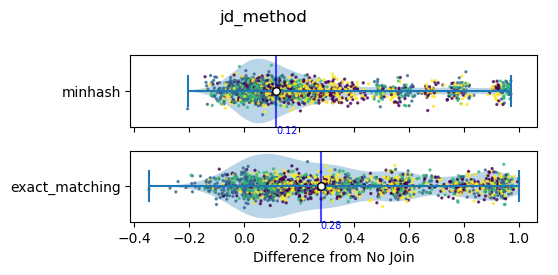

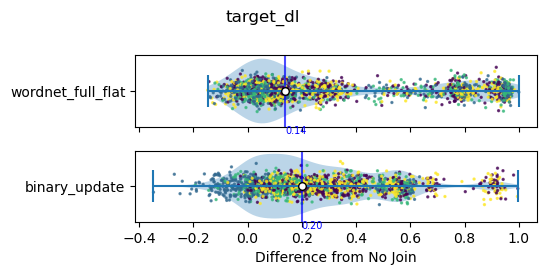

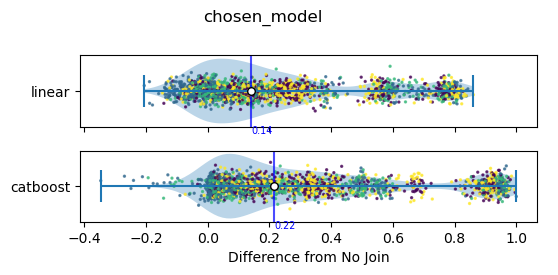

In [540]:
target_variable = "jd_method"
for tg in ["jd_method", "target_dl", "chosen_model"]:
    data, values_dict, label_mapping = prepare_data(results_depleted, tg)
    violin_plot(data, values_dict, label_mapping, tg)
    # break

In [541]:
values["estimator"]

estimator
list[str]
"[""highest_containment"", ""stepwise_greedy_join"", … ""best_single_join""]"
"[""best_single_join"", ""highest_containment"", … ""highest_containment""]"


In [525]:
from itertools import combinations

In [526]:
best_value

{'target_dl': 'wordnet_full_flat',
 'jd_method': 'exact_matching',
 'estimator': 'full_join',
 'chosen_model': 'catboost'}

In [527]:
list(combinations(best_value.items(), 3))

[(('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('estimator', 'full_join')),
 (('target_dl', 'wordnet_full_flat'),
  ('jd_method', 'exact_matching'),
  ('chosen_model', 'catboost')),
 (('target_dl', 'wordnet_full_flat'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost')),
 (('jd_method', 'exact_matching'),
  ('estimator', 'full_join'),
  ('chosen_model', 'catboost'))]

In [528]:
for comb in combinations(best_value.items(), 2):
    case1, case2 = comb
    t_f = results_depleted.filter(
        (pl.col(case1[0]) == case1[1]) & (pl.col(case1[0]) == case1[1])
    )

exact_matching
minhash
wordnet_full_flat
binary_update
catboost
linear


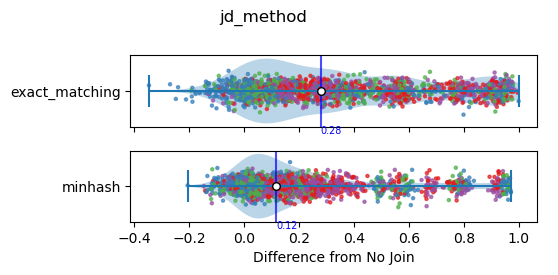

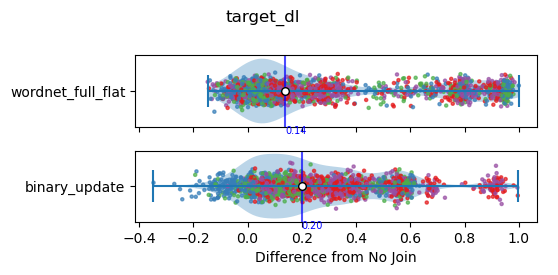

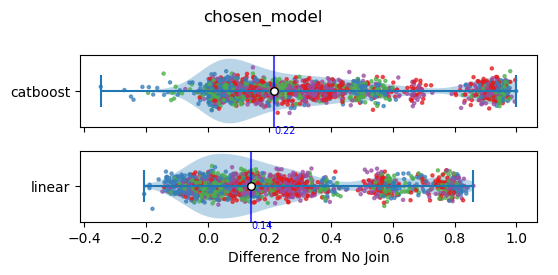

In [529]:
target_variable = "jd_method"
for tg in ["jd_method", "target_dl", "chosen_model"]:
    data, values_dict, label_mapping = prepare_data(results_depleted, tg)
    violin_plot(data, values_dict, label_mapping, tg)
    # break

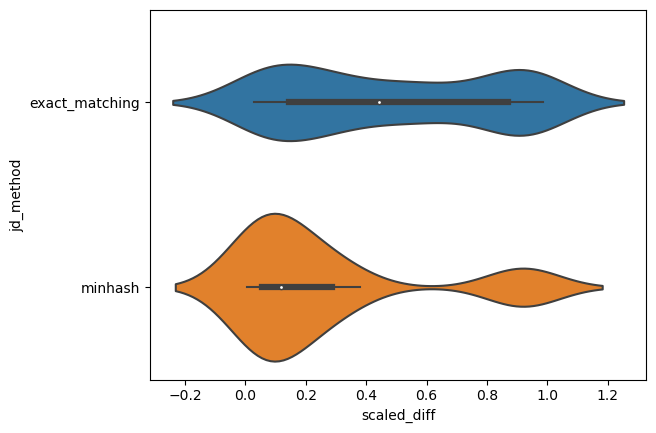

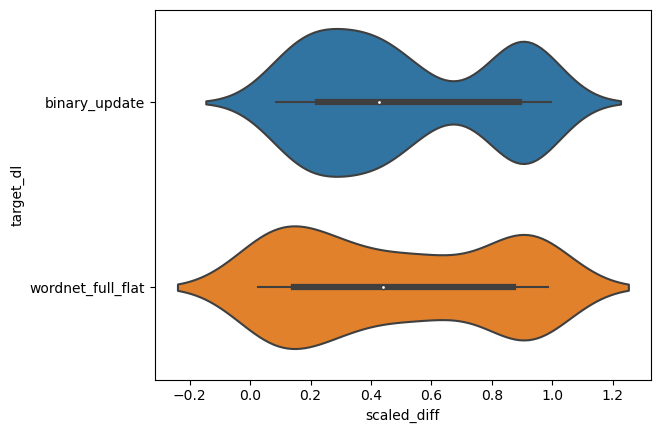

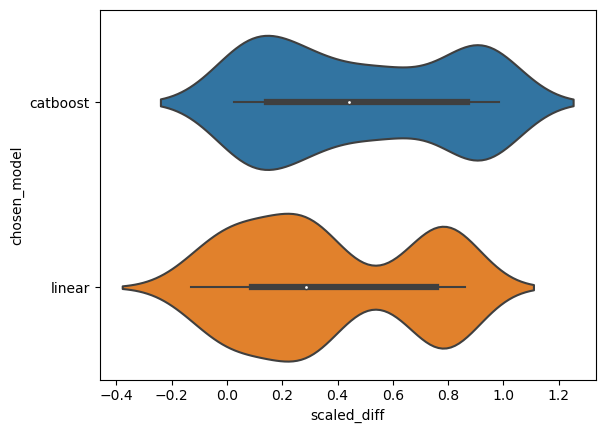

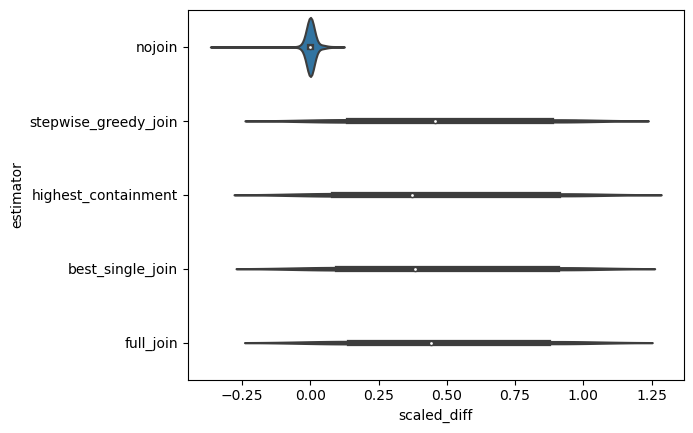

In [530]:
for tg in ["jd_method", "target_dl", "chosen_model", "estimator"]:
    filter_values = [(k, v) for k, v in best_value.items() if k != tg]
    c1, c2, c3 = filter_values
    t_f = results_depleted.filter(
        (pl.col(c1[0]) == c1[1]) & (pl.col(c2[0]) == c2[1]) & (pl.col(c3[0]) == c3[1])
    )

    fig, ax = plt.subplots(1)
    sns.violinplot(data=t_f.to_pandas(), x="scaled_diff", y=tg, ax=ax)

<Axes: xlabel='scaled_diff', ylabel='jd_method'>

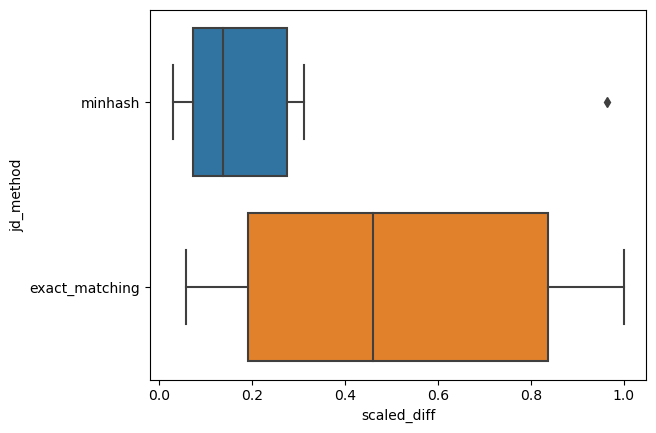

In [495]:
sns.boxplot(data=t_f.to_pandas(), x="scaled_diff", y="jd_method")

In [491]:
filter_values

[('target_dl', 'wordnet_full_flat'),
 ('estimator', 'full_join'),
 ('chosen_model', 'catboost')]